In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append('../')

from cancer_classification.models import get_model_by_name
from cancer_classification.utils.config import load_config
from cancer_classification.training.trainer import Trainer
from cancer_classification.utils.datasets import ThumbnailsDataset
import matplotlib.pyplot as plt
import numpy as np

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

In [2]:
default_config = "../configs/base/default_arguments.yaml"
config_path = "../configs/alex/111023/resnet18_epoch10_ASAM_sgd_crossentropy_bs12_reduce_lr_1vsall.yaml"
config = load_config(config_path, default_config)
config['trainer']['ckpt_load'] = 'last'
config['trainer']['ckpt_dir'] = "../ckpts"

|| INFO -- Config file:  -- (config.py:48 cancer_classification.utils.config) ||
|| INFO -- Config file:  -- (config.py:48 cancer_classification.utils.config) ||


trainer:
  augmentations: false
  batch_size: 12
  ckpt_dir: ./ckpts
  ckpt_load: null
  classification_type: onevsall
  criterion: crossentropy
  freeze_layers: false
  lr_scheduler: reduce_lr
  max_lr: 0.05
  min_lr: 0.0001
  minimizer: asam
  minimizer_cfg:
    eta: 1.0e-08
    rho: 0.05
  model_name: resnet18
  n_epochs: 10
  opt_cfg:
    lr: 0.003
    momentum: 0.09
  optimizer: sgd
  pretrained: false
  save_interval: 1
  scheduler_cfg:
    cooldown: 0
    eps: 1.0e-08
    factor: 0.05
    min_lr: 1.0e-12
    mode: min
    patience: 2
    threshold: 0.0001
    threshold_mode: rel
  train_freeze_layers: []
  train_log_interval: 1
  val_log_interval: 2
validation_final:
  testset: val
  validate: false
validation_intermediate:
  interval: 1
  validate: true



In [4]:
# model = get_model_by_name(config)

In [2]:
from pathlib import Path
DATA_PATH = Path("../data/")
thumbnails_files = DATA_PATH / "train_thumbnails"
train_df = pd.read_csv(DATA_PATH / "train.csv")
train_df = train_df[~train_df['is_tma']]

# Distribution of channels

In [71]:
from skimage.exposure import equalize_adapthist

In [47]:
import histomicstk as htk

def rgb_to_stains(image, plot: bool=False):
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    # print('stain_color_map:', stain_color_map, sep='\n')


    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
            'eosin',        # cytoplasm stain
            'null']         # set to null if input contains only two stains

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(image, W)

    if plot:
        # Display results
        for i in range(imDeconvolved.Stains.shape[-1]):
            plt.figure()
            plt.imshow(imDeconvolved.Stains[:, :, i], cmap='gray')
            _ = plt.title(stains[i], fontsize=12)
            plt.show()
    return np.array(imDeconvolved.Stains)

  0%|          | 0/513 [00:00<?, ?it/s]

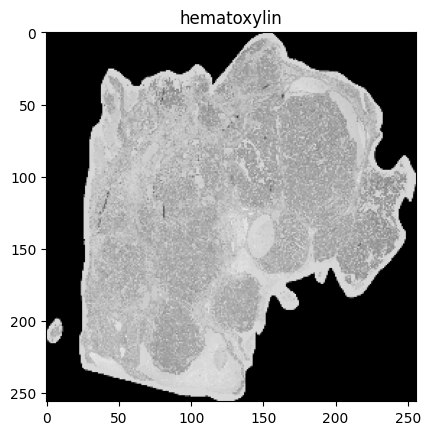

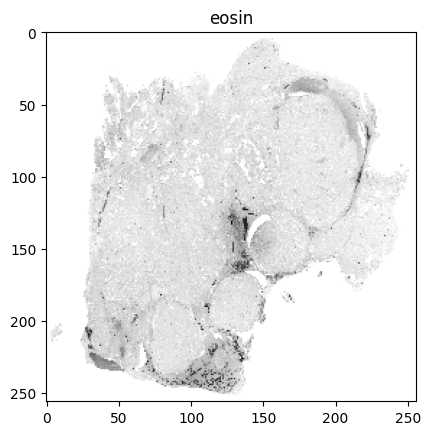

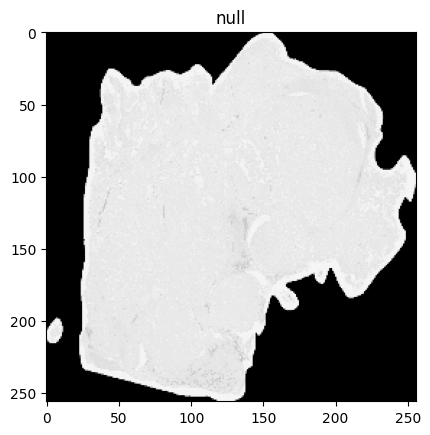

100%|██████████| 513/513 [04:25<00:00,  1.93it/s, to_stains=0]


In [160]:
import os
from skimage.io import imread, imsave
from tqdm import tqdm
import gc
import cv2
from collections import defaultdict

resize = True
first = True
equalize = False
fill_black = False
plot = False
reds = defaultdict(list)
greens = defaultdict(list)
blues = defaultdict(list)
hematoxylins = defaultdict(list)
eosins = defaultdict(list)
nulls = defaultdict(list)
labels = []
n_classes = train_df['label'].nunique()

pbar = tqdm(os.listdir(thumbnails_files))
for file in pbar:
    file_path = thumbnails_files / file
    image_id = Path(file).stem.split('_')[0]
    labels.append(train_df[train_df['image_id'] == int(image_id)]['label'].item())
    image = imread(file_path)
    if fill_black:
        image = np.where(image == 0, 255, image)
    if resize:
        image = cv2.resize(image, (256, 256))

   
    stains = rgb_to_stains(image, plot=first)
    pbar.set_postfix(to_stains=True)

    if equalize:
        stains = equalize_adapthist(stains)
        if plot:
            for i in range(stains.shape[-1]):
                plt.figure()
                plt.imshow(stains[..., i], cmap='gray')
                # _ = plt.title(stains[i], fontsize=12)
                plt.show()



    hematoxylins[labels[-1]].append(stains[..., 0].flatten())
    eosins[labels[-1]].append(stains[..., 1].flatten())
    nulls[labels[-1]].append(stains[..., 2].flatten())
    reds[labels[-1]].append(image[..., 0].flatten())
    greens[labels[-1]].append(image[..., 1].flatten())
    blues[labels[-1]].append(image[..., 2].flatten())
    gc.collect()
    first = False
    pbar.set_postfix(to_stains=False)

In [162]:
label

'EC'

In [179]:
get_quantile(hematoxylins, label)

array([141, 209, 209, ..., 207, 212,  25], dtype=uint8)

In [181]:
def min_max_scaler(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

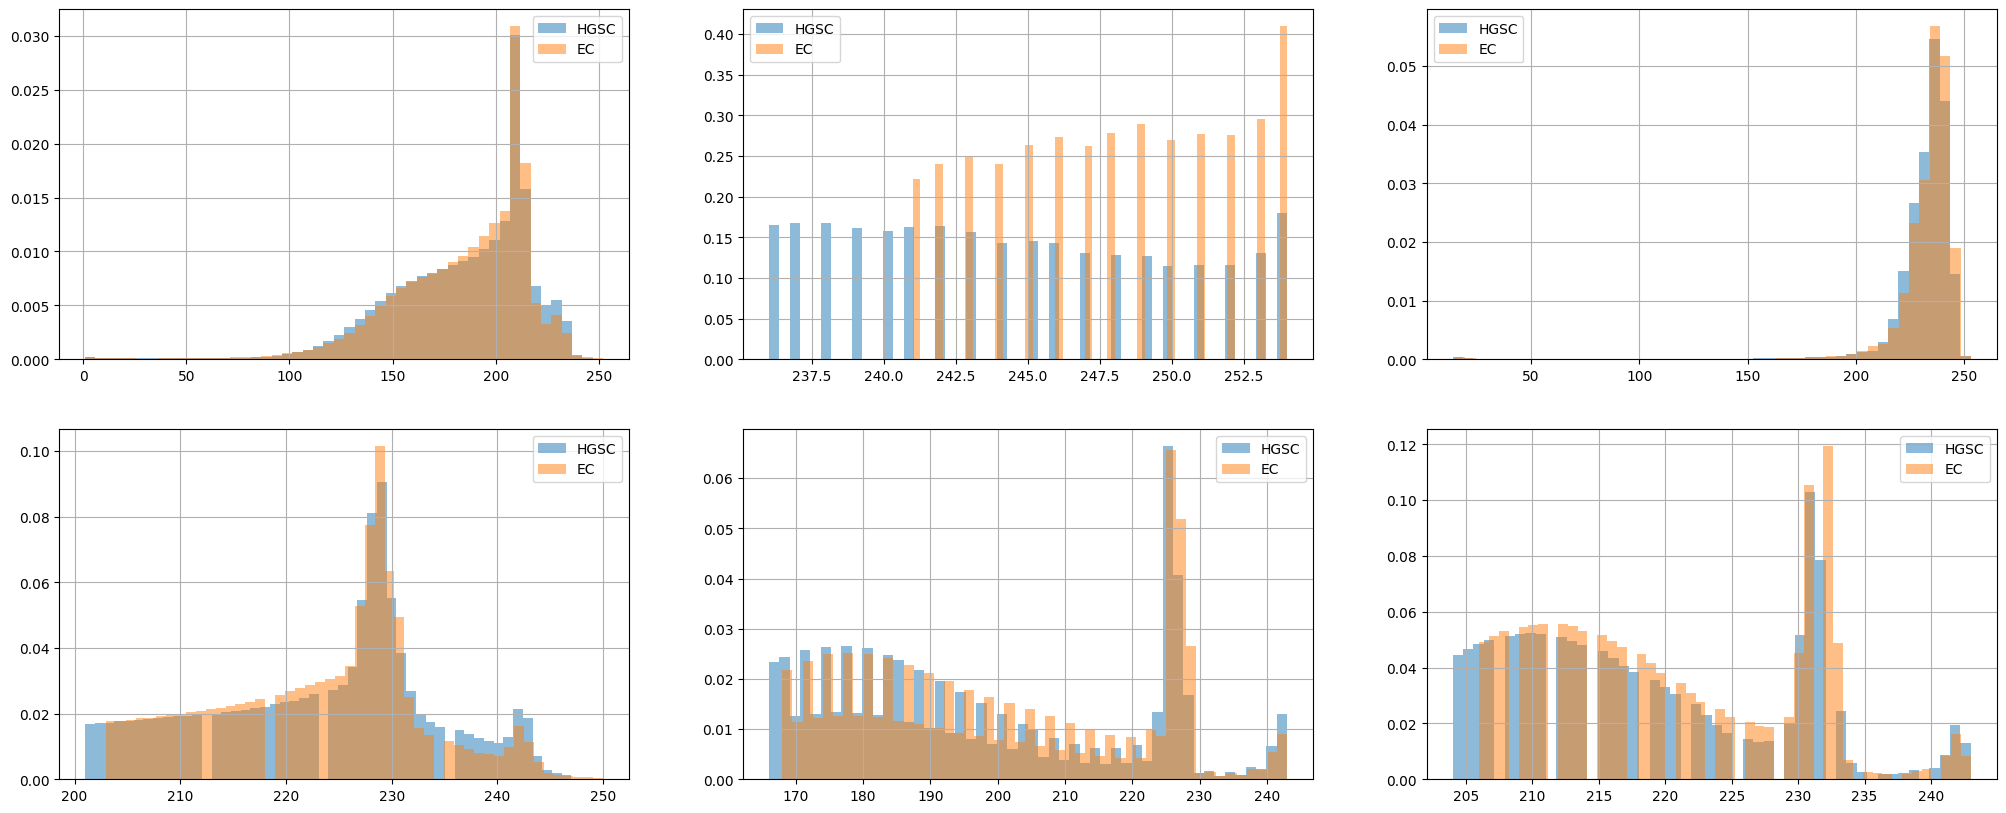

In [183]:
labels_to_view = ['HGSC', 'EC']

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(25, 10))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

get_quantile = lambda arr, label: np.array(arr[label])[(np.array(arr[label]) > np.quantile(np.array(arr[label]), 0.3)) & (np.array(arr[label]) < np.quantile(arr[label], 0.999))]

for i, label in enumerate(labels_to_view):
    # hematoxylins[label] = get_quantile(hematoxylins, label)
    # eosins[label] = get_quantile(eosins, label)
    # nulls[label] = get_quantile(nulls, label)

    # reds[label] = get_quantile(reds, label) #reds[label][reds[label] != 0]
    # greens[label] = get_quantile(greens, label) #greens[label][greens[label] != 0]
    # blues[label] = get_quantile(blues, label) #blues[label][blues[label] != 0]

    axes[0, 0].hist(np.array(hematoxylins[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)
    axes[0, 1].hist(np.array(eosins[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)
    axes[0, 2].hist(np.array(nulls[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)

    axes[1, 0].hist(np.array(reds[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)
    axes[1, 1].hist(np.array(greens[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)
    axes[1, 2].hist(np.array(blues[label]).flatten(), color=colors[i], bins=50, alpha=.5, label=label, density=True)

for ax_ in axes:
    for ax in ax_:
        ax.grid()
        ax.legend()

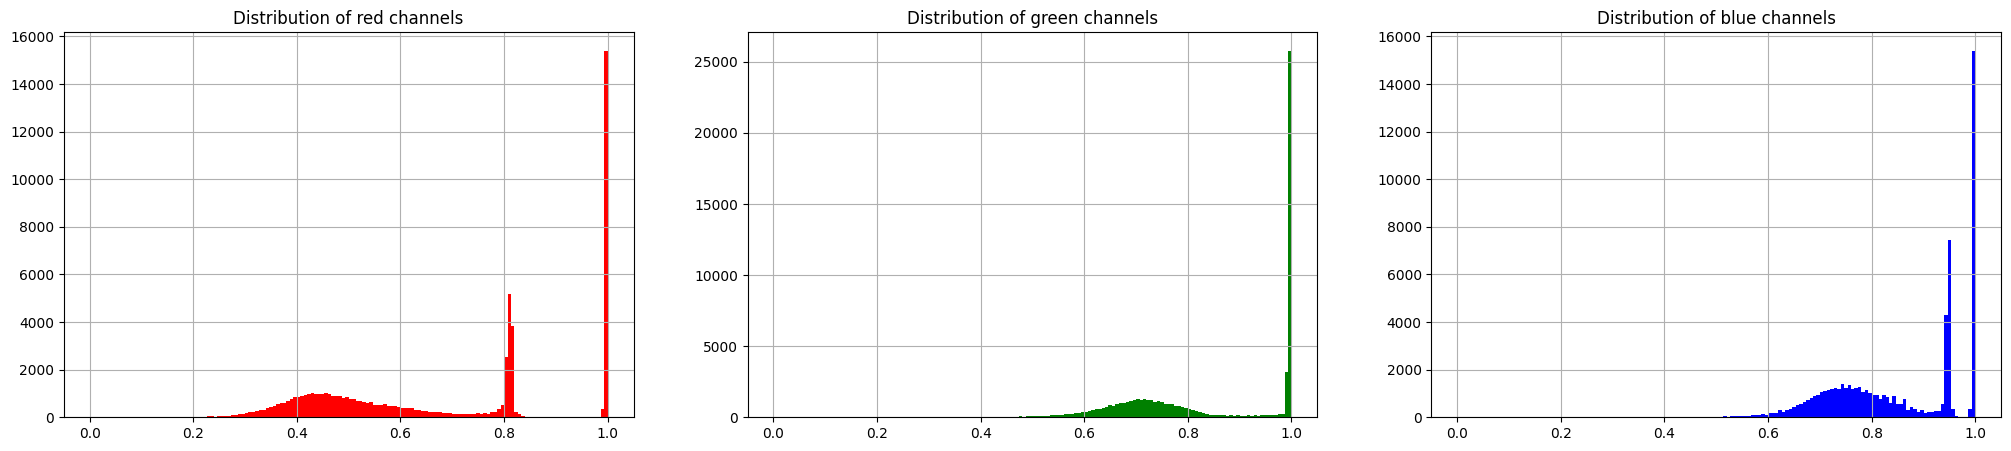

In [85]:
reds = hematoxylins[hematoxylins != 0]
greens = eosins[eosins != 0]
blues = nulls[nulls != 0]


fig, axes = plt.subplots(ncols=3, figsize=(25, 5))
axes[0].hist(reds, bins=150, color='r')
axes[0].set_title("Distribution of red channels")
axes[1].hist(greens, bins=150, color='g')
axes[1].set_title("Distribution of green channels")
axes[2].hist(blues, bins=150, color='b')
axes[2].set_title("Distribution of blue channels")

for ax in axes:
    ax.grid()


plt.show()

In [86]:
reds = np.stack(hematoxylins)
greens = np.stack(eosins)
blues = np.stack(nulls)

In [113]:
from sklearn.manifold import TSNE as tsne
reds_embedded = tsne(
    n_components=2, learning_rate='auto',
    random_state=0, perplexity=3,  metric="cosine"
).fit_transform(reds)

greens_embedded = tsne(
    n_components=2, learning_rate='auto',
    random_state=0, perplexity=3,  metric="cosine"
).fit_transform(greens)

blues_embedded = tsne(
    n_components=2, learning_rate='auto',
    random_state=0, perplexity=3, metric="cosine"
).fit_transform(blues)

assert reds_embedded.shape[-1] == 2

c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Aleksey Ryabykin\AppData\Local\Progra

In [115]:
labels = np.array(labels)

labels[labels != "HGSC"].shape

(296,)

In [123]:
reds_embedded.shape, labels.shape

((513, 2), (513,))

(296, 2)

In [120]:
# np.where(np.array(labels)!="HGSC")

In [127]:
reds_embedded = reds_embedded[labels != "HGSC", :] #np.delete(reds_embedded, np.where(np.array(labels)!="HGSC"), axis=0)
greens_embedded =greens_embedded[labels != "HGSC", :] #np.delete(greens_embedded, np.where(np.array(labels)!="HGSC"), axis=0)
blues_embedded = blues_embedded[labels != "HGSC", :]# np.delete(blues_embedded, np.where(np.array(labels)!="HGSC"), axis=0)

assert reds_embedded.shape == greens_embedded.shape == blues_embedded.shape

In [112]:
reds_embedded.shape

(217, 2)

(296,)

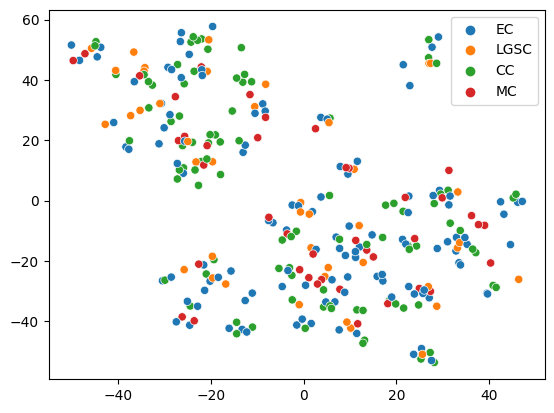

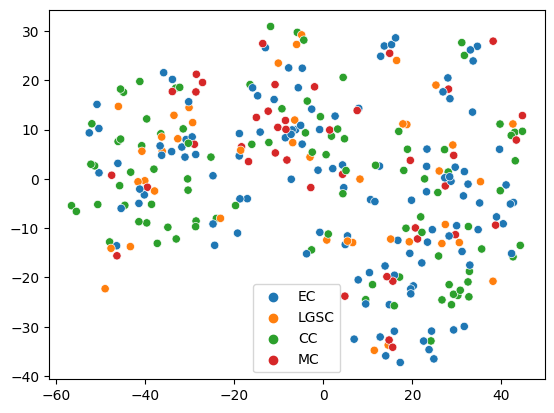

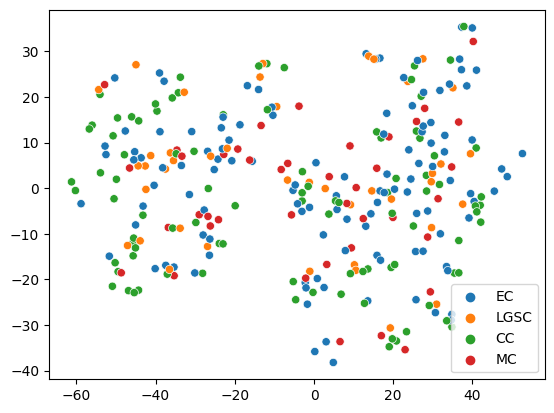

In [128]:
import seaborn as sns

sns.scatterplot(x=reds_embedded[:, 0], y=reds_embedded[:, 1], hue=labels[labels != "HGSC"])
plt.show()
sns.scatterplot(x=greens_embedded[:, 0], y=greens_embedded[:, 1], hue=labels[labels != "HGSC"])
plt.show()

sns.scatterplot(x=blues_embedded[:, 0], y=blues_embedded[:, 1], hue=labels[labels != "HGSC"])
plt.show()


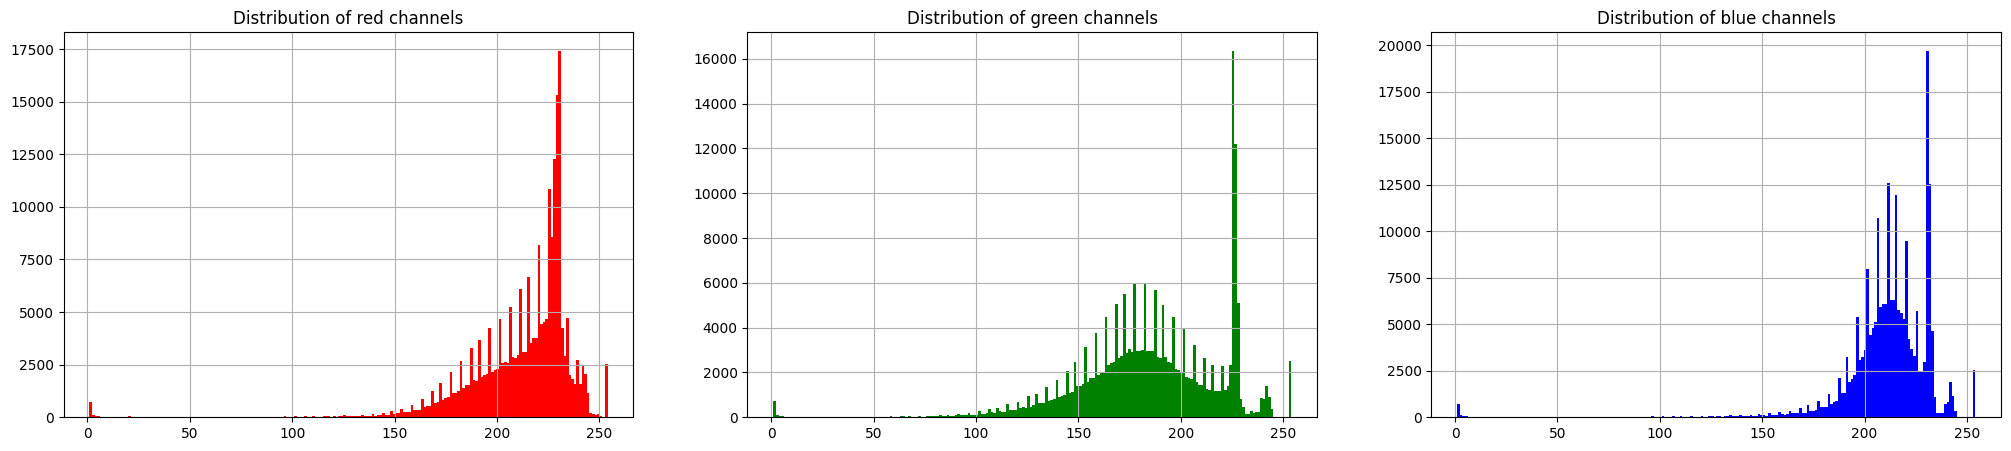

In [15]:
reds = reds[reds != 0]
greens = greens[greens != 0]
blues = blues[blues != 0]


fig, axes = plt.subplots(ncols=3, figsize=(25, 5))
axes[0].hist(reds, bins=200, color='r')
axes[0].set_title("Distribution of red channels")
axes[1].hist(greens, bins=200, color='g')
axes[1].set_title("Distribution of green channels")
axes[2].hist(blues, bins=200, color='b')
axes[2].set_title("Distribution of blue channels")

for ax in axes:
    ax.grid()


plt.show()

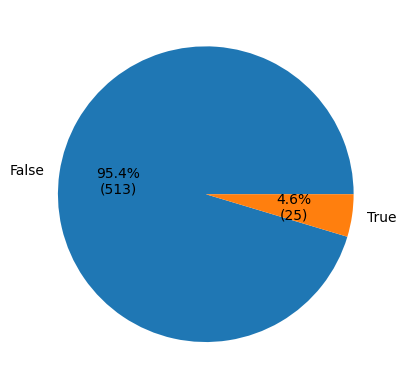

In [12]:

s = train_df['is_tma'].value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s));

In [ ]:
set(<path_to_images>) - set(<path_to_thumnails_images>)

In [27]:
train_set = ThumbnailsDataset(train_df, mode="train", data_path="../data/train_thumbnails/")
train_set, val_set = torch.utils.data.random_split(train_set, [453, 60])
train_loader = DataLoader(train_set, batch_size=8)

In [31]:
config['trainer']['n_classes'] = 2
trainer = Trainer(config)

c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading checkpoint ..\ckpts\resnet18\model_resnet18_10112023.231729_10.pth


|| INFO -- Tensorboard dir: ./tb_logs/resnet18/10112023.233840 -- (trainer.py:104 cancer_classification.training.trainer) ||
|| INFO -- Tensorboard dir: ./tb_logs/resnet18/10112023.233840 -- (trainer.py:104 cancer_classification.training.trainer) ||


Initialized model ResNet
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

In [37]:


train_df['coded_label'] = label_encoder.transform(train_df['label'])

# s = train_df['coded_label'].value_counts()
# plt.pie(s,labels = s.index, autopct=autopct_format(s))

In [36]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["label"])
val_set = ThumbnailsDataset(val_df, data_path='../data/train_thumbnails/')
val_loader = DataLoader(val_set, batch_size=8)

In [38]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle
from IPython.display import clear_output
import time
import numpy as np
label_encoder_binary = pickle.load(open('../label_encoderonevsall.pkl', "rb"))

trainer.model.train(False)
with torch.no_grad():
    for data, target in val_loader:
        # clear_output(wait=True)
        data = data.to('cuda')
        output = trainer.model(data).argmax(1).cpu().numpy()
        output = label_encoder_binary.inverse_transform(output)

        labels_target = label_encoder.inverse_transform(target)
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 15))
        fig.suptitle(f"Accuracy: {np.mean(target.cpu().numpy() == output) * 100}%")
        for i, image in enumerate(data):
            axes[i // 4][i % 4].imshow(data[i, ...].permute((1,2,0)).cpu().numpy())
            axes[i // 4][i % 4].set_title(
                f"""
                Prediction: {output[i]}\nTarget: {labels_target[i]}
                """)
        plt.show()
        time.sleep(5)
        clear_output(wait=True)
        print(output)

['not_HDSC' 'not_HDSC' 'not_HDSC' 'not_HDSC' 'not_HDSC' 'not_HDSC'
 'not_HDSC' 'not_HDSC']


KeyboardInterrupt: 